In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.optim as optim

from data_loader import DataLoader
from model import KGCN

In [3]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument(
    '--dataset', type=str, default='movie', help='dataset type'
)
parser.add_argument(
    '--aggregator', type=str, default='concat', help='which aggregator to use'
)
parser.add_argument(
    '--n_epochs', type=int, default=10, help='the number of epochs'
)
parser.add_argument(
    '--neighbor_sample_size', type=int, default=4, help='the number of neighbors to be sampled'
)
parser.add_argument(
    '--dim', type=int, default=32, help='dimension of user and entity embeddings'
)
parser.add_argument(
    '--n_iter', type=int, default=2, help='number of iterations when computing entity representation'
)
parser.add_argument(
    '--batch_size', type=int, default=6000, help='batch size'
)
parser.add_argument(
    '--l2_weight', type=float, default=1e-7, help='weight of l2 regularization'
)
parser.add_argument(
    '--lr', type=float, default=2e-2, help='learning rate'
)
parser.add_argument(
    '--ratio', type=float, default=0.1, help='size of training dataset'
)

args = parser.parse_args(['--l2_weight', '1e-7'])

In [4]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
df_dataset = data_loader.load_dataset()
print((df_dataset['label'] != 0).sum())
print((df_dataset['label'] != 0).sum()/len(df_dataset['label']))
df_dataset

Build dataset dataframe ...
Done
6750811
0.5


,userID,itemID,label
0,43756,2112,1
1,105399,58958,0
2,70259,54684,0
3,19649,2147,1
4,95220,284,0
...,...,...,...
13501617,122461,89830,0
13501618,30839,8126,0
13501619,15512,1331,1
13501620,86197,70060,0


In [5]:
kg = data_loader.load_kg()

Construct knowledge graph ... Done


In [6]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        
        return user_id, item_id, label

In [7]:
# train / test splits
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)

x_train, x_test, y_train, y_test  = train_test_split(x_train, y_train, test_size=0.2, shuffle=False, random_state=999)

train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size,
)

In [39]:
# prepare network, loss function, and optimizer
num_user, num_entity, num_relation = data_loader.get_num()
print(num_user)

user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

net = KGCN(
    num_user, num_entity, num_relation, kg, args, device,
).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(
    net.parameters(), lr=args.lr, weight_decay=args.l2_weight,
)

138493
device:  cuda


In [40]:
# train steps start here
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        print('[Epoch {}]auc_score: '.format(epoch+1), total_roc / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  0.4698682387066151
[Epoch 1]test_loss:  0.24966704780640808
[Epoch 1]auc_score:  0.9591963131674971
[Epoch 2]train_loss:  0.19663172610392227
[Epoch 2]test_loss:  0.20501944066389746
[Epoch 2]auc_score:  0.9735276034363691
[Epoch 3]train_loss:  0.15764483533676157
[Epoch 3]test_loss:  0.21685828657253928
[Epoch 3]auc_score:  0.9742108268532618
[Epoch 4]train_loss:  0.11207812243444815
[Epoch 4]test_loss:  0.2236943688729535
[Epoch 4]auc_score:  0.9743864120188632
[Epoch 5]train_loss:  0.0642000624423754
[Epoch 5]test_loss:  0.22492933921192004
[Epoch 5]auc_score:  0.9738554388666253
[Epoch 6]train_loss:  0.03898071081799491
[Epoch 6]test_loss:  0.21797446355871533
[Epoch 6]auc_score:  0.9750685986575695
[Epoch 7]train_loss:  0.026522910439805515
[Epoch 7]test_loss:  0.21662283364845358
[Epoch 7]auc_score:  0.9755040325583366
[Epoch 8]train_loss:  0.020307198251425213
[Epoch 8]test_loss:  0.21181773426740066
[Epoch 8]auc_score:  0.9761412975097251
[Epoch 9]train_lo

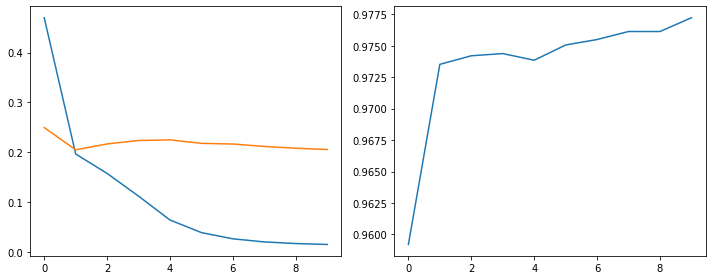

In [41]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()

In [42]:
print('train_loss', loss_list)
print('test_loss', test_loss_list)
print('accuracy', auc_score_list)

train_loss [0.4698682387066151, 0.19663172610392227, 0.15764483533676157, 0.11207812243444815, 0.0642000624423754, 0.03898071081799491, 0.026522910439805515, 0.020307198251425213, 0.0170583964157618, 0.015230413282371142]
test_loss [0.24966704780640808, 0.20501944066389746, 0.21685828657253928, 0.2236943688729535, 0.22492933921192004, 0.21797446355871533, 0.21662283364845358, 0.21181773426740066, 0.2081669637042543, 0.2056513091792231]
accuracy [0.9591963131674971, 0.9735276034363691, 0.9742108268532618, 0.9743864120188632, 0.9738554388666253, 0.9750685986575695, 0.9755040325583366, 0.9761412975097251, 0.9761409946034287, 0.9772375145859283]
